<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects-II/blob/main/Competitive_Analysis_AI_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Competitor Analysis Using Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System

## Business Context
Performing competitor analysis with a Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System.

## Problem Scenario
Conducting a robust competitor analysis of a company is a time-consuming and research-intensive process that may be prone to errors for example, outdated information.

Analysts spend significant time gathering data, identifying relevant competitors, and synthesizing insights into actionable recommendations.

## Objective
To address above mentioned challenges, a Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System is proposed.

This system will perform competitor analysis of a given company by comparing it with its key rivals in the relevant industry using the latest available web data.

Users will input a company name (e.g., "Tesla", "Caterpillar", "Ely Lilly", "Microsoft") and receive a well-structured report, comparing that company to its primary competitors (e.g., in the electric vehicle sector for Tesla), by leveraging a multi-agent collaborative architecture powered by RAG capabilities.

The system should deliver rapid, accurate, and actionable insights.

## Solution Approach

A Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System is implemented using a **sequential workflow pattern**.

This system automates competitor analysis by breaking down the task into distinct steps handled by specialized agents.

The sequential pattern ensures each step builds on the previous one. Also, incorporating RAG to retrieve and augment data from a vector database for context-aware insights.


**Below are the key components of the implementation:**

### State Management

The workflow uses a Pydantic-based state `CompetitiveAnalysisState` to track variables like:
- company name,
- generated questions,
- search results,
- vectorstore status, and
- the final report.

### Tools
- `suggest_questions`: Generates relevant questions for competitor analysis using the LLM.
- `fetch_search_results`: Searches the web via Tavily API to fetch answers for the questions.
- `store_in_chromadb`: Stores question-answer pairs in ChromaDB for efficient retrieval.
- `generate_report`: Uses RAG to query the vectorstore and draft a structured report.




### Agents

- `Question Generator Agent`: Validates the company, identifies its sector, and generates analysis questions.

- `Data Retrieval and Storage Agent`: Fetches answers from the web and stores them in the vector database.

- `Report Drafter Agent`: Retrieves stored data via RAG and generates a professional, actionable report with sections like Executive Summary, Company Overview, Key Competitors, Strengths/Weaknesses, Market Strategies, and Recommendations.




### Workflow (Sequential Pattern)

The system uses LangGraph's StateGraph to define nodes for each agent.
Edges connect the nodes sequentially as indicated below.

`START → Question Generation → Data Retrieval/Storage → Report Drafting → END.`

The final output is formatted competitive analysis report, displayed in Markdown for readability.

# Installing the Libraries

Installing the libraries:
- **openai==1.99.9** → Official OpenAI client library for interacting with GPT models.  
- **langchain==0.3.27** → Core framework for building applications powered by LLMs.  
- **langchain-openai==0.3.30** → LangChain integration for OpenAI models.  
- **langchain-community==0.3.27** → Community-contributed LangChain modules (tools, integrations).  
- **langgraph==0.6.4** → Build and manage multi-step workflows or agent graphs for LLM-powered systems.  
- **langchain-chroma==0.2.5** → Connector for using **ChromaDB** as a vector database with LangChain.  
- **chromadb==1.0.16** → Open-source vector database for storing and retrieving embeddings.  
- **langchain-tavily==0.2.11** → Integration for the **Tavily API** (specialized web search + retrieval for RAG).  

#Install required packages
!pip install -q openai==1.99.9 \
                langchain==0.3.27 \
                langchain-openai==0.3.30 \
                langchain-community==0.3.27 \
                langgraph==0.6.4 \
                langchain-chroma==0.2.5 \
                chromadb==1.0.16 \
                langchain-tavily==0.2.11

# Setting up the Environment (5 Marks)

## **Importing the relevant packages**

In [1]:
import os, json, random, datetime, chromadb, logging

from typing import TypedDict, List, Optional, Dict, Tuple, Literal

from pydantic import BaseModel, Field,ConfigDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import StructuredTool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.retrievers import BaseRetriever
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_tavily import TavilySearch

from IPython.display import Image, display, Markdown

from google.colab import userdata

# Hide warnings/logs from Chroma
# This code mutes the following telemetry error in ChromaDB:
# ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

## **Instantiating the required variables (5 Marks)**

Set the environment variables.

To securely connect with external APIs (like OpenAI and Tavily), we’ll set up our **environment variables**.  
This ensures our API keys are not hard-coded directly in the notebook, keeping them safe.

- **OPENAI_API_KEY**
- **OPENAI_BASE_URL**
- **TAVILY_API_KEY**

After running this cell, your notebook will be able to access both **OpenAI** and **Tavily APIs** securely.


In [2]:
# Set environment variables
openai_api_key = userdata.get('OPEN_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('tavily_search_api_key')
os.environ['OPENAI_BASE_URL'] = "https://aibe.mygreatlearning.com/openai/v1"

Now that our environment variables are set, let's initialize the **core models** we'll use in this project:

Instantiating the LLM and the embedding model using the `ChatOpenAI` and `OpenAIEmbeddings` methods respectively.

In [3]:
llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature = 0 # setting the temperature as zero for the model to be more deterministic
)

# Initialize OpenAIEmbeddings for generating text embeddings
embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='text-embedding-3-small'
)

To enable **Retrieval-Augmented Generation (RAG)**, we need a place to store and query text embeddings.  
Here, we'll use **ChromaDB**, an open-source vector database.

Setting up the Chroma vector database client and a Chroma vector store collection for storing and retrieving search results.

In [4]:
# ChromaDB set up Persistent client
chromadb_client = chromadb.PersistentClient(path="./assist_db")

# Set up vectorstore
vectorstore = Chroma(
    collection_name="search_result_collection",
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./assist_db"
)


# **State Definitions (6 Marks)**

Lets define the Pydantic models for structured outputs - 'QuestionSuggestion' and the overall state - 'CompetitiveAnalysisState'  .
State Definition ensure type safety and structure the data passed between agents and nodes.

## **QuestionSuggestion (3 Marks)**


This model will help ensure that the responses from the LLM follow a **consistent format**, making them easier to validate and use later.

- Create a class that inherits from `BaseModel`.  
- Fields include:
  - **sector** → The industry sector of the company.  
  - **is_valid_company** →  A boolean flag for whether the company name is recognized.  
  - **questions** → A list of suggested competitive analysis questions.  
  - **error_message** → Optional field to capture any errors that occur.  

- The `Field()` argument ensures that **default values** and **descriptions** are available for each attribute.  


In [5]:
class QuestionSuggestion(BaseModel):
    """
    Structured output model for competitive analysis questions
    """
    sector: Optional[str] = Field(None, description="The industry sector the company operates in")

    is_valid_company: bool = Field(..., description="Whether the provided company name is valid/known, else False")

    questions: List[str] = Field(default_factory=list, description="List of generated competitive analysis questions")

    error_message: Optional[str] = Field(None,description="Error message if any step fails")

## **Competitive Analysis State (3 marks)**

Next, we’ll create a state object for keeping track off the competitive analysis that keeps track of all the information our pipeline generates and updates during the competitive analysis workflow.

This will act as a “shared memory” object, making it easier to pass data between steps in the system.

- Fields include:
  - **company_name** → The company being analyzed.  
  - **max_num_of_questions** → The maximum number of questions to generate (use a constant as the default).  
  - **sector** → The industry sector (optional).  
  - **is_valid_company** → Boolean flag to mark if the company is recognized (optional).  
  - **question_list** → List of generated analysis questions (optional).  
  - **qna_results** → Stores answers to questions as a list of dictionaries (optional).  
  - **vectorstore** → Chroma vector database instance for retrieval.  
  - **chromadb_insert_status** → Tracks whether data was successfully stored in Chroma (optional).  
  - **report** → Final competitive analysis report (optional).  
  - **error_message** → Captures any error details (optional).

- The `model_config` setting allows **non-Pydantic types** (e.g., Chroma objects).


In [6]:
#Setting maximum limit to number of genetated questions
MAX_NUM_OF_QUESTIONS = 10

In [7]:
class CompetitiveAnalysisState(BaseModel):
    company_name: str
    max_num_of_questions: int = Field(default = MAX_NUM_OF_QUESTIONS, description = 'Maximum number of questions to generate')
    sector: Optional[str] = None
    is_valid_company: Optional[bool] = None
    question_list: Optional[List[str]] = None
    qna_results: Optional[List[Dict]] = None
    vectorstore: Chroma = vectorstore
    chromadb_insert_status: Optional[bool] = None
    report: Optional[str] = None
    error_message: Optional[str] = None
    model_config = ConfigDict(arbitrary_types_allowed=True)

# **Tools (13 Marks)**

## **Tavily Search Tool (1 Mark)**

To enrich our competitive analysis, **Tavily Search** will be used to fetch **relevant company information** that can later be embedded into our vector store and used for RAG.
The following code
- Initializes a `TavilySearch` instance with the following parameters:
  - **max_results** → The maximum number of results to return  
  - **include_answer** → Whether to include a synthesized answer from Tavily.  
  - **include_raw_content** → Whether to return raw page content along with the results.
  - **search_depth** → Set the level of search (`"basic"` or `"advanced"`).  

In [8]:
search = TavilySearch(max_results = 2,
                      include_answer=True,
                      include_raw_content=True,
                      search_depth="advanced")

Below section defines the tools used by the agents for,
- Suggesting questions,
- Fetching search results,
- Storing data in ChromaDB, and
- Generating the report.

## **Suggest Questions Tool (3 marks)**


The Suggest Questions Tool is a **custom LangChain tool** that uses an LLM to generate structured competitive analysis questions for a given company.  

This tool will serve as the **entry point** in our pipeline for validating company information and generating insightful prompts for deeper analysis.

The function `suggest_questions` contains a  **prompt** that instructs the LLM to:
     - Validate if the company is real/known.  
     - Identify its sector.  
     - Generate targeted competitor analysis questions (e.g., competitors, pricing, supply chain, strengths/weaknesses, market opportunities) and **invokes the LLM** with a structured output format (using the `QuestionSuggestion` model).  
The `@tool` decorator ensures that it can be called by agents within LangChain.


In [9]:
@tool # Define LangChain Tool
def suggest_questions(company_name: str, max_num_of_questions: int) -> str:
    """Suggest list containing questions for the given company name."""
    prompt = f"""
For the given company name: {company_name}

1. Validate if it's a known company: Set 'is_valid_company' to true if it's a recognized company; otherwise, false.
2. Identify its primary 'sector'.
3. Generate up to {max_num_of_questions} targeted questions for a comprehensive competitor analysis. Focus on areas that enable detailed comparisons and insights:
   - Identifying key competitors and market share.
   - Comparing products, pricing, technology, and supply chain.
   - Analyzing strengths, weaknesses, and differentiators (e.g., innovation, brand perception, customer service).
   - Exploring market trends, regulatory challenges, and growth opportunities.
   - Proposing strategies for outcompeting rivals (e.g., differentiation, partnerships, sustainability).
Ensure questions are specific, diverse, and actionable to support a structured report with sections like Executive Summary, Company Overview, Key Competitors, Strengths/Weaknesses, Market Strategies, and Recommendations.
"""
    print("[INSIDE TOOL] suggest_questions")
    try:
        # Invoke the LLM with structured output enforcement with the appropriate Pydantic model using the llm.with_structured_output method
        # This returns a Pydantic object (not raw text) if the model and wrapper support it

        result = llm.with_structured_output(QuestionSuggestion).invoke(prompt)

        print(f"[Identified SECTOR] {result.sector}")

        sector = str(result.sector)

        print(f"[IS VALID COMPANY] {result.is_valid_company}")

        is_valid_company = str(result.is_valid_company)

        print(f"[QUESTION GENERATED LIST] {result.questions}")

        questions_list = result.questions

        return json.dumps({
            "sector": sector,
            "is_valid_company": is_valid_company,
            "questions": questions_list,
            "error_message": result.error_message or ""
        })
    except Exception as e:

        print(f"Error: {str(e)}")

        return json.dumps({
            "sector": "",
            "is_valid_company": False,
            "questions": [],
            "error_message": str(e)
        })

## **Fetch Search Result Tool (3 Marks)**

The Fetch Search Result tool will take each question, query the **Tavily Search API**, and collect the results.

The function **iterates** through the `question_list` and for each question:
     - Call `search.invoke({"query": question})` to get Tavily search results.  
     - Check if the result contains an `"answer"`.  
     - Store the pair (`question`, `answer`) in a list of dictionaries.  
Additionally, the function can:
- **Handle missing answers** by storing an empty string.
- Handle errors** with a `try/except` block and log them for debugging.  
- Return the **final results as a JSON string**.

In [10]:
@tool # Define LangChain Tool
def fetch_search_results(question_list: List[str]) -> str:
    """
    Iterate through 'question_list' and for each question, search for answers using the Tavily Search API.
    Output a JSON string containing a list of dictionaries with 'question' and 'answer'.
    """
    print("[INSIDE TOOL]: fetch_search_results")

    results = []

    # Itertate through the list of questions and process using the search tool
    for question in question_list:
        try:
            print("[QUESTION]:", question)

            # Invoke the Tavily search tool
            search_result = search.invoke({"query":question})

            print("[SEARCH RESULT]:", search_result)

            if 'answer' in search_result and search_result['answer']:
                answer = search_result['answer'].lower()
                print("[ANSWER TO BE STORED]:", answer)
                results.append({
                    "question": question,
                    "answer": answer
                })

            else:
                print("[WARNING]: No answer found for question", question)
                results.append({
                    "question": question,
                    "answer": ""
                })

        except Exception as e:
            print("[ERROR]:", str(e))
            results.append({
                "question": question,
                "answer": ""
            })

    return json.dumps(results)

## **Store in ChromaDB Tool (4 Marks)**

After fetching question-answer pairs, they must be stored in **ChromaDB** so they can later be retrieved during the analysis.  
This tool will embed the answers and insert them into the vector store along with metadata for traceability.

The function `store_in_chromadb`:
- Loop through each question–answer dictionary.  
- **Skip empty answers** (don’t embed/store them).  
- For valid answers:  
    - Create a `documents` list containing the answer text.  
    - Create `metadatas` with fields such as:  
        - `question` → the original question  
        - `source_type` → `"answer"`  
        - `search_success` → whether a valid answer was found  
    - Create unique `ids` for each entry (e.g., `"doc_1"`, `"doc_2"`).  
- Use `vectorstore.add_texts()` to insert documents, metadata, and IDs into ChromaDB.  

In [11]:
@tool # Define LangChain Tool
def store_in_chromadb(qna_results: List[Dict]) -> str:
    """
    Stores a list of question-answer dictionaries in a ChromaDB vectorstore after embedding.
    Returns a JSON string indicating success or failure.
    """
    print("[INSIDE TOOL]: store_in_chromadb")
    success_count = 0
    # Iterate over the list containing qna results
    for index, d in enumerate(qna_results, start=1):
        try:

            question = d['question']
            answer = d["answer"]

            search_success = bool(answer)
            if not answer:
                print(f"[WARNING]: Skipping empty answer for question: {question}")
                continue
            documents = [answer]
            metadatas = [{
                "question": question,
                "source_type": "answer",
                "search_success": search_success
            }]
            ids = [f"doc_{index}"]
            print("[DOCUMENTS]:", documents)
            print("[METADATA]:", metadatas)
            print("[IDS]:", ids)

            # Add documents, metadata and ids to the vectorstore using the .add_texts method
            vectorstore.add_texts(documents, metadatas, ids)

            # Increase the success_count counter
            success_count += 1

            print(f"[SUCCESS]: Added entry for question: {question}")
        except Exception as e:

            print(f"[ERROR]: Failed to add entry for question '{d.get('question', '')}': {str(e)}")

    chromadb_insert_status = success_count == len([d for d in qna_results if d["answer"]])

    return json.dumps({"chromadb_insert_status": chromadb_insert_status})

## **Generate Report Tool (2 Marks)**

The `generate_report` tool will be used to define precisely how to use retrieved context for generating the report by
- using the retrieved context as the primary source and comparing competitors across dimensions (market share, products, pricing, tech, supply chain, customer sentiment).
- highlighting differentiators and actionable strategies.
- structuring the final output into the named sections and citing context where relevant.

The functions builds a `human` message that requests a report for the given `company_name` and `sector` and includes a `{context}` placeholder which will be filled at runtime with retrieved documents from the vectorstore and combine messages into a `ChatPromptTemplate.from_messages([...])`

In [12]:
@tool # Define LangChain Tool
def generate_report(company_name: str, sector: str) -> str:
    """
    Generate a competitive analysis report using RAG from the vectorstore.
    Note: Vectorstore is accessed from the state in the node, not passed as an argument.
    """
    print("[INSIDE TOOL]: generate_report")
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
Role: You are an advanced competitor analysis tool designed to generate detailed, data-driven insights on competing companies.
Your core function is to analyze competitors based on provided inputs (company name and sector) by leveraging retrieved context from a vector database (answers to targeted questions on competitors, market share, strengths/weaknesses, trends, etc.).
Instructions:
   - Use the provided context (question-answer pairs from web searches) as the primary source for all insights.
   - Perform in-depth comparisons (e.g., market share, product offerings, pricing, customer sentiment) by synthesizing relevant answers.
   - Highlight key differentiators (e.g., technological advantages, operational strengths, weaknesses) drawn from context.
   - Identify competitors’ strengths to emulate or counter (e.g., brand loyalty, R&D investments) and weaknesses to exploit (e.g., customer service gaps, supply chain inefficiencies).
   - Propose actionable strategies (e.g., differentiation tactics, pricing adjustments, targeted marketing) based on analyzed data.
   - Compare competitors to uncover industry trends (e.g., emerging technologies, shifting consumer preferences) from context.
   - Synthesize findings into a comprehensive market strategy (e.g., whitespace opportunities, risk mitigation).
   - Prioritize recommendations based on competitive urgency (e.g., short-term wins vs. long-term positioning).
   - Structure the report with sections: Executive Summary, Company Overview, Key Competitors, Strengths and Weaknesses, Market Strategies, and Recommendations. Cite context where relevant.
"""),
    ("human", f"Generate report for {company_name} in the {sector} sector using retrieved context: {{context}}")
])
    return prompt  # Return the prompt template to be used in the node

# **Agents (26 Marks)**

## **Initialize the Agents (2 Marks)**

Below section creates reactive agents using LangChain's create_react_agent. Each agent is assigned specific tools:
- question_generator_agent: Uses suggest_questions tool.
- data_retrieval_storage_agent: Uses fetch_search_results and store_in_chromadb tool.
- report_drafter_agent: Uses generate_report tool.

### Questions Generator Agent

In [13]:
question_generator_agent = create_react_agent(
    llm,
    tools = [suggest_questions]
)

### Data Retrieval & Storage Agent

In [14]:
data_retrieval_storage_agent = create_react_agent(
    llm,
    tools = [fetch_search_results, store_in_chromadb]
)

### Report Drafter Agent

In [15]:
report_drafter_agent = create_react_agent(
    llm,
    tools = [generate_report]
)

# **Defining the Nodes (18 Marks)**

## **Question Generator Node (6 Marks)**

Question Generator Node - Generates questions and updates state.

The run_question_generator node invokes the question-generation agent to produce structured JSON output and then parses that output to update the pipeline state by:
- invoking the agent with a short system+human message (company name, max questions) and retrieving the agent response.
- searching responses in reverse for the last JSON block (to find the structured payload) and using json.loads to parse it.
- updating CompetitiveAnalysisState fields: sector, is_valid_company, question_list, and error_message.
- handling errors and parsing failures gracefully by logging the issue and setting safe defaults (sector="", is_valid_company=False, question_list=[], error_message=<error>).
- returning the updated state for downstream nodes to consume.

In [16]:
def run_question_generator(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_question_generator")
    messages = [
        SystemMessage(content="Generate questions for competitive analysis."),
        HumanMessage(content=f"Company: {state.company_name}, Max questions: {state.max_num_of_questions}")
    ]
    try:
        # Invoke the question generator agent using the .invoke method
        response = question_generator_agent.invoke({"messages":messages})
        # Find the last message with valid JSON content
        last_message = None
        for msg in reversed(response["messages"]):
            if hasattr(msg, 'content') and isinstance(msg.content, str) and msg.content.strip().startswith('{'):
                last_message = msg.content
                break
        if last_message is None:
            last_message = response["messages"][-1].content if response["messages"] else ""
            print(f"[WARNING]: No valid JSON message found, using last message: {last_message}")

        try:
            output = json.loads(last_message)
            state.sector = output.get("sector", "")
            state.is_valid_company = output.get("is_valid_company", False)
            state.question_list = output.get("questions", [])
            state.error_message = output.get("error_message", "")
            print(f"[PARSED OUTPUT]: sector={state.sector}, is_valid_company={state.is_valid_company}, questions={state.question_list}")
        except json.JSONDecodeError as e:
            print(f"[ERROR]: Failed to parse JSON from question_generator_agent: {str(e)}")
            print(f"[RAW RESPONSE CONTENT]: {last_message}")
            state.error_message = f"Failed to parse JSON from question_generator_agent: {str(e)}"
            state.sector = ""
            state.is_valid_company = False
            state.question_list = []
    except Exception as e:
        print(f"[ERROR]: Question generator agent failed: {str(e)}")
        state.error_message = f"Question generator agent failed: {str(e)}"
        state.sector = ""
        state.is_valid_company = False
        state.question_list = []
    return state

## **Data Retrieval and Storage Node (6 Marks)**

This Node fetches and stores the search results.

The run_data_retrieval_storage node fetches answers for generated questions and stores them in ChromaDB, then updates the pipeline state by:
- verifying questions exist and short-circuiting with an error if none were generated.
- invoking the data_retrieval_storage agent with a short system + human message (questions) and retrieving the agent response.
- parsing the last message as JSON to populate state.qna_results (the list of question–answer dicts).
- extracting the `store_in_chromadb` tool call output from `response["messages"][-1].tool_calls` (if present) to set state.chromadb_insert_status, with a fallback to read `chromadb_insert_status` from the parsed last message.
handling JSON parse errors by setting state.error_message to a descriptive message.
- returning the updated CompetitiveAnalysisState for downstream nodes to consume.


In [17]:
def run_data_retrieval_storage(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_data_retrieval_storage")
    if not state.question_list:
        state.error_message = "No questions generated."
        return state
    messages = [
        SystemMessage(content="Fetch search results and store in vector DB."),
        HumanMessage(content=f"Questions: {state.question_list}")
    ]
    # Invoke the data retrieval and storage agent using the invoke method
    response = data_retrieval_storage_agent.invoke({"messages":messages})
    last_message = response["messages"][-1].content
    try:
        # Assuming the tool output is the only content or the last message content
        # If the agent adds conversational text, this will need to be adjusted to extract tool calls
        qna_results = json.loads(last_message).get("qna_results", [])
        state.qna_results = qna_results

        # Check if the last message was the store_in_chromadb tool call and extract its output
        tool_calls = getattr(response["messages"][-1],"tool_calls", None)

        if tool_calls and tool_calls[0]['function']['name'] == 'store_in_chromadb':
             state.chromadb_insert_status = json.loads(tool_calls[0]['function']['arguments']).get("chromadb_insert_status", False)
        else:
             # Fallback if the last message wasn't the tool call (e.g., just the qna_results from fetch_search_results)
            state.chromadb_insert_status = json.loads(last_message).get("chromadb_insert_status", False)

    except json.JSONDecodeError:
        state.error_message = "Failed to parse Q&A results or ChromaDB insert status."
    return state

## **Report Drafter Node (6 Marks)**

Below Node generates the report leveraging RAG and prints a preview.

The run_report_drafter node builds a RAG-powered report by retrieving stored Q&A context and invoking the report-generation prompt, then updates the pipeline state by:
- creating a retriever from state.vectorstore (search_kwargs={"k": 10}) and querying it for competitive-analysis documents for the company.
- handling the "no documents" case by setting state.report and state.error_message and short-circuiting.
- concatenating retrieved documents' `page_content` into a single `context` string for the LLM.
- invoking the `generate_report` tool to obtain a `ChatPromptTemplate` (expects a prompt template, not a final string).
- validating the returned object is a `ChatPromptTemplate`; on mismatch, set `state.error_message` and `state.report` appropriately and return.
- composing the prompt template with the LLM (e.g., `chain = prompt_template | llm`) and invoking the chain with `{"context": context}` to produce the report.
storing the generated report in `state.report`, logging a brief preview, and handling any exceptions by setting `state.error_message` and a failure `state.report`.
- returning the updated CompetitiveAnalysisState for downstream consumption.


In [18]:
def run_report_drafter(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_report_drafter")
    try:
        retriever = state.vectorstore.as_retriever(search_kwargs={"k": 10})
        retrieved_docs = retriever.invoke(f"Competitive analysis data for {state.company_name}")
        if not retrieved_docs:
            state.report = "No data found in vectorstore for report generation."
            state.error_message = "No data found in vectorstore for report generation."
            print("[WARNING]: No documents retrieved for report generation.")
            return state

        context = "\n\n".join([doc.page_content for doc in retrieved_docs])
        print("[RETRIEVED CONTEXT]:", context[:200] + "..." if len(context) > 200 else context)

        # Directly invoke the generate_report tool to get the prompt template
        prompt_template = generate_report.invoke({
            "company_name": state.company_name,
            "sector": state.sector
        })

        # Ensure prompt_template is a ChatPromptTemplate
        if not isinstance(prompt_template, ChatPromptTemplate):
            state.error_message = f"Expected ChatPromptTemplate, got {type(prompt_template)}"
            state.report = f"Failed to generate report: Invalid prompt template type."
            print(f"[ERROR]: {state.error_message}")
            return state

        # # Create a chain and invoke it with the context
        # chain = prompt_template | llm
        # report_content = chain.invoke({
        #     "company_name": state.company_name,
        #     "sector": state.sector,
        #     "context": context})
        # state.report = report_content.content
        # print("[REPORT GENERATED]:", state.report[:200] + "..." if len(state.report) > 200 else state.report)

        # 2) Using report_drafter_agent instead of manual prompt_template | llm (the other approach was explored and it functioned perfectly)
        # Using this approach because the report_drafter_agent would not have been used otherwise.
        messages = [
            SystemMessage(
                content=("Generate report for competitive analysis.")),
            HumanMessage(content=(
                    f"Company: {state.company_name}\n"
                    f"Sector: {state.sector}\n\n"
                    f"Context from vector store:\n{context}"
                )),]

        # Agent will reason + call generate_report tool as needed
        agent_response = report_drafter_agent.invoke({"messages": messages})

        msgs = agent_response.get("messages", [])
        if not msgs:
            state.error_message = "report_drafter_agent returned no messages."
            state.report = "Failed to generate report: empty agent response."
            print("[ERROR]: report_drafter_agent returned no messages.")
            return state

        last_msg = msgs[-1]

        # 3) Normalize output to string
        if isinstance(last_msg, AIMessage):
            state.report = last_msg.content
        else:
            # if it's something else, still try to grab content or str()
            content = getattr(last_msg, "content", None)
            state.report = content if content is not None else str(last_msg)

        preview = (
            state.report[:200] + "..."
            if isinstance(state.report, str) and len(state.report) > 200
            else state.report
        )
        print("[REPORT GENERATED]:", preview)
        state.error_message = ""

    except Exception as e:
        state.error_message = f"Report drafter agent failed: {str(e)}"
        state.report = f"Failed to generate report: {str(e)}"
        print(f"[ERROR]: Report drafter agent failed: {str(e)}")
    return state

# **Workflow (5 Marks)**

Building the StateGraph workflow using LangGraph.

Implement the "Sequential design pattern" by adding nodes for each step (question generation, data retrieval/storage, report drafting) in sequence and connects them with edges to define the sequential flow from START to END.

In [19]:
graph = StateGraph(CompetitiveAnalysisState)

graph.add_node("question generation", run_question_generator)
graph.add_node("data retrieval/storage", run_data_retrieval_storage)
graph.add_node("report drafting", run_report_drafter)

graph.add_edge(START, "question generation")
graph.add_edge("question generation", "data retrieval/storage")
graph.add_edge("data retrieval/storage", "report drafting")
graph.add_edge("report drafting", END)

competitive_analysis = graph.compile()

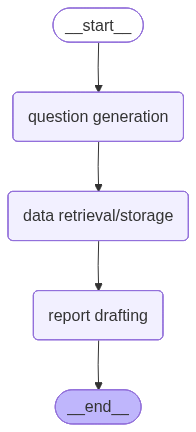

In [20]:
try:
    display(Image(competitive_analysis.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("some error")
    pass

# **Execution (1 Marks)**

Invoking the workflow with the company  name as input.

 - Example 1

In [21]:
# sample input -> Tesla, Infosys, Deloitte, Great Learning
companyname = "Tesla"
# Invoke the workflow using the given company name
result = competitive_analysis.invoke({"company_name": companyname})

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Automotive and Energy
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] ["Who are Tesla's main competitors in the electric vehicle market, and what is their respective market share?", "How do Tesla's vehicle models compare in terms of features, performance, and pricing against competitors like Ford, GM, and Rivian?", 'What technological advancements does Tesla have over its competitors, particularly in battery technology and autonomous driving?', "What are the strengths and weaknesses of Tesla's supply chain compared to other automotive manufacturers?", "How does Tesla's brand perception differ from that of its competitors, and what factors contribute to this perception?", 'What are the current market trends in the electric vehicle industry, and how is Tesla positioned to capitalize on these trends?', 'What regulatory challenges does Tesla face in different markets, and how do these impact its competitiv

For better readability, displaying the report in Markdown format

In [22]:
display(Markdown(result['report']))

# Competitive Analysis Report for Tesla in the Automotive and Energy Sector

## Executive Summary
Tesla remains a dominant player in the electric vehicle (EV) market, although its market share is experiencing a decline. The company continues to leverage its EV business to fund broader ambitions in autonomy and robotics. Despite facing regulatory challenges in key markets, Tesla's high-end model strategy and advanced technology keep it at the forefront of the industry. This report analyzes Tesla's competitive landscape, key competitors, strengths and weaknesses, market strategies, and actionable recommendations.

## Company Overview
Tesla, Inc. is a leading manufacturer of electric vehicles and energy solutions. The company is known for its innovative approach to automotive design, battery technology, and self-driving capabilities. Tesla's market value reflects its foundational role in the EV sector, although it faces increasing competition and regulatory scrutiny.

## Key Competitors
Tesla's main competitors in the electric vehicle market include:
- **Ford**: Established brand with strong performance in the EV sector.
- **General Motors (GM)**: Competes with a range of electric models and has a strong market presence.
- **Hyundai Group**: Offers competitive EV options and has a growing market share.
- **BYD Co., Ltd.**: Currently leads in global EV sales, posing a significant threat to Tesla's market position.
- **Emerging Brands**: Companies like Geely and Rivian are innovating in the electric truck segment and attracting consumer interest.

## Strengths and Weaknesses
### Strengths
- **Advanced Technology**: Tesla leads in battery technology with long-range, fast-charging capabilities and advanced autonomous driving features.
- **Brand Recognition**: High brand awareness and a strong market presence, although sentiment is mixed due to Elon Musk's public persona.
- **Vertical Integration**: Strong supply chain management and adaptability, enhancing operational efficiency.
- **Partnerships**: Collaborations with companies like Eaton and Panasonic improve battery technology and integrate solar solutions.

### Weaknesses
- **Regulatory Challenges**: Facing scrutiny in the U.S., EU, and China, which impacts innovation and market entry strategies.
- **Market Share Decline**: Loss of U.S. market share to competitors like BYD and Ford.
- **Reliance on Chinese Materials**: Heavy dependence on Chinese supply chains poses risks due to geopolitical tensions.

## Market Strategies
Tesla's current strategies include:
- **High-End Model Focus**: Continuing to generate profits through premium vehicle offerings.
- **Emerging Market Expansion**: Targeting growth in markets like India and Southeast Asia, with plans for a gigafactory in India.
- **Differentiation through Technology**: Emphasizing advanced battery technology and superior customer service, including over-the-air software updates.

## Recommendations
1. **Enhance Regulatory Engagement**: Proactively address regulatory challenges by engaging with policymakers to shape favorable regulations for autonomous driving and EVs.
2. **Diversify Supply Chain**: Reduce reliance on Chinese materials by exploring alternative suppliers and local sourcing options to mitigate geopolitical risks.
3. **Strengthen Brand Perception**: Focus on improving customer sentiment through community engagement and positive public relations to counteract negative perceptions linked to Elon Musk.
4. **Expand Product Offerings**: Consider introducing more affordable models to capture a broader market segment and compete effectively with emerging brands.
5. **Leverage Technological Innovations**: Continue investing in R&D for battery technology and autonomous driving to maintain a competitive edge.

## Conclusion
Tesla's position in the automotive and energy sector is strong, but it must navigate regulatory challenges and increasing competition. By focusing on strategic enhancements in regulatory engagement, supply chain diversification, brand perception, product offerings, and technological innovation, Tesla can solidify its market leadership and drive future growth.

 - Example 2

In [23]:
companyname = "Caterpillar"
# Invoke the workflow using the given company name
result = competitive_analysis.invoke({"company_name": companyname})

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Construction and Mining Equipment
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] ["Who are Caterpillar's top three competitors in the construction and mining equipment sector, and what is their respective market share?", "How does Caterpillar's product range compare to its competitors in terms of features, pricing, and technology?", 'What are the key differentiators that set Caterpillar apart from its competitors in the industry?', 'What are the strengths and weaknesses of Caterpillar compared to its main competitors?', "How does Caterpillar's supply chain efficiency compare to that of its competitors?", 'What recent market trends are impacting the construction and mining equipment industry, and how is Caterpillar positioned to respond?', 'What regulatory challenges does Caterpillar face in different markets, and how do these affect its competitive standing?', 'What growth opportunities exist for Cate

In [24]:
display(Markdown(result['report']))

# Competitive Analysis Report for Caterpillar

## Executive Summary
Caterpillar Inc. is a leading player in the construction and mining equipment sector, recognized for its strong brand reputation, extensive product range, and commitment to innovation. However, it faces significant competition from companies like Komatsu, Volvo, and Hitachi, as well as challenges from low-cost manufacturers and supply chain disruptions. This report analyzes Caterpillar's competitive landscape, strengths and weaknesses, market strategies, and provides actionable recommendations for maintaining and enhancing its market position.

## Company Overview
Caterpillar is renowned for its durable and reliable heavy machinery, with a strong focus on advanced technology and fuel efficiency. The company has a global distribution network that supports its extensive product offerings, which include construction and mining equipment. Caterpillar is actively expanding into emerging markets and investing in autonomous and electrified products to drive future growth.

## Key Competitors
Caterpillar's primary competitors include:
- **Komatsu**: Competes closely in heavy machinery with a strong focus on innovation.
- **Volvo Construction Equipment**: Known for its commitment to sustainability and advanced technology.
- **Hitachi Construction Machinery**: Offers a range of construction equipment with a focus on efficiency and reliability.

These competitors challenge Caterpillar's market share and require strategic responses to maintain its leadership position.

## Strengths and Weaknesses
### Strengths:
- **Strong Brand Reputation**: Caterpillar is perceived as highly reliable, driving customer loyalty.
- **Global Distribution Network**: Extensive reach allows for efficient delivery and service.
- **Innovation and R&D Leadership**: Leading in research and development advancements, particularly in autonomous and electrified products.
- **Cost-Efficient Operations**: Lean operations enhance profitability and market responsiveness.

### Weaknesses:
- **Low Innovation Rates**: Compared to competitors, there is a perception of slower innovation in certain product lines.
- **Limited Emerging Market Connections**: While expanding, Caterpillar still faces challenges in fully penetrating emerging markets.
- **Customer Service Gaps**: Particularly for smaller clients, there is room for improvement in customer service.

## Market Strategies
Caterpillar is responding to recent market trends, including increased demand for autonomous equipment and a recovery in construction. The company is investing in:
- **Autonomous Trucks**: To enhance operational efficiency and meet market demand.
- **AI-Driven Growth**: Leveraging technology to improve product offerings and customer engagement.
- **Sustainable Solutions**: Focusing on environmentally friendly products to align with industry trends.

## Recommendations
1. **Enhance Customer Service**: Improve support for smaller clients to strengthen relationships and loyalty.
2. **Accelerate Innovation**: Increase investment in R&D to keep pace with competitors and address low innovation rates.
3. **Expand Emerging Market Presence**: Develop targeted strategies to penetrate emerging markets more effectively.
4. **Leverage Strategic Partnerships**: Collaborate with technology firms to enhance product offerings and market reach.
5. **Focus on Sustainability**: Continue to innovate in sustainable solutions to meet growing consumer demand for environmentally friendly products.

## Conclusion
Caterpillar is well-positioned in the construction and mining equipment sector, but it must address its weaknesses and capitalize on its strengths to maintain its competitive edge. By focusing on customer service, innovation, and market expansion, Caterpillar can continue to thrive in a challenging and evolving industry landscape.

- Example 3

In [25]:
companyname = "Pepsico"
# Invoke the workflow using the given company name
result = competitive_analysis.invoke({"company_name": companyname})

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Food and Beverage
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] ["Who are Pepsico's top three competitors in the global food and beverage market, and what is their respective market share?", "How does Pepsico's product portfolio compare to its competitors in terms of variety, quality, and innovation?", 'What are the pricing strategies employed by Pepsico compared to its main competitors, and how do they affect market positioning?', 'What technological advancements is Pepsico implementing in its production and supply chain processes compared to its competitors?', 'What are the key strengths and weaknesses of Pepsico relative to its competitors in terms of brand perception and customer loyalty?', "How does Pepsico's customer service and engagement strategies differ from those of its competitors?", 'What current market trends are impacting the food and beverage industry, and how is Pepsico positioned to

In [26]:
display(Markdown(result['report']))

### Competitive Analysis Report for Pepsico in the Food and Beverage Sector

#### Executive Summary
Pepsico is a leading player in the food and beverage sector, known for its extensive product portfolio, strong brand presence, and innovative strategies. This report analyzes Pepsico's competitive landscape, highlighting its strengths, weaknesses, and market strategies, while providing actionable recommendations to enhance its competitive advantage.

#### Company Overview
Pepsico operates in the food and beverage sector, offering a diverse range of high-quality products. The company is recognized for its continuous innovation and effective marketing strategies, which contribute to its significant market share and financial performance. Pepsico employs cost leadership and competitive pricing strategies, collaborating with major retailers like Walmart to influence pricing and outmaneuver competitors.

#### Key Competitors
Pepsico's primary competitors include:
- **Coca-Cola**: The market leader with the largest share, known for its strong brand loyalty and extensive distribution network.
- **Keurig Dr. Pepper**: A significant player with a diverse beverage portfolio, competing closely with Pepsico.
- **Red Bull**: A major competitor in the energy drink segment, known for its strong brand identity and marketing.

#### Strengths and Weaknesses
**Strengths:**
- **Diverse Product Portfolio**: Pepsico's wide range of products caters to various consumer preferences, including healthier options.
- **Strong Brand Loyalty**: Ranked above Mondelez but below Unilever and Coca-Cola in customer loyalty scores, Pepsico benefits from a loyal customer base.
- **Innovation**: Continuous product innovation, including recent acquisitions like Siete Foods, positions Pepsico favorably in emerging markets.

**Weaknesses:**
- **Regulatory Challenges**: Pepsico faces food safety and health standard regulations in international markets, which can impact operations.
- **Market Positioning**: While Pepsico ranks second in market share, it must continuously innovate to keep pace with Coca-Cola.

#### Market Strategies
Pepsico is capitalizing on current market trends favoring healthier food and beverage options. The company is expanding its offerings in snacking, protein, and functional beverages, particularly in emerging markets. Additionally, Pepsico leverages AI-driven logistics and advanced analytics to enhance operational efficiency and cost-effectiveness.

#### Recommendations
1. **Enhance Product Innovation**: Continue to invest in R&D for healthier product lines to meet evolving consumer preferences.
2. **Strategic Partnerships**: Form alliances with startups and academic institutions to drive innovation and sustainability initiatives.
3. **Market Expansion**: Focus on expanding in emerging markets by tailoring products to local tastes and preferences.
4. **Leverage Technology**: Utilize AI and automation for predictive maintenance and inventory optimization to improve operational efficiency.
5. **Customer Engagement**: Strengthen customer service strategies through real-time social media interaction and gamification to deepen consumer connections.

#### Conclusion
Pepsico is well-positioned in the food and beverage sector, but it must remain vigilant against competitive pressures from Coca-Cola and others. By focusing on innovation, strategic partnerships, and enhanced customer engagement, Pepsico can solidify its market position and drive future growth.

 - Example 4

In [27]:
companyname = "Ely Lilly"
# Invoke the workflow using the given company name
result = competitive_analysis.invoke({"company_name": companyname})

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Pharmaceuticals
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] ['Who are the top 5 competitors of Eli Lilly in the pharmaceutical sector, and what is their respective market share?', "What are the key therapeutic areas where Eli Lilly's products excel compared to its competitors?", "How does Eli Lilly's pricing strategy compare to that of its main competitors for similar products?", 'What innovative technologies or research initiatives is Eli Lilly pursuing that differentiate it from its competitors?', 'What are the strengths and weaknesses of Eli Lilly in terms of product portfolio compared to its key competitors?', "How does Eli Lilly's supply chain efficiency compare to that of its competitors, and what improvements can be made?", 'What are the current market trends affecting the pharmaceutical industry, and how is Eli Lilly positioned to capitalize on these trends?', 'What regulatory challenges do

In [28]:
display(Markdown(result['report']))

# Competitive Analysis Report for Ely Lilly in the Pharmaceuticals Sector

## Executive Summary
Ely Lilly operates in a highly competitive pharmaceuticals sector, facing significant challenges and opportunities. The company is strategically positioned with a diversified product portfolio and innovative drug mechanisms, particularly in the obesity treatment market. However, it must navigate regulatory scrutiny and intense competition from major players like Novo Nordisk and Pfizer. This report analyzes Ely Lilly's competitive landscape, strengths, weaknesses, and market strategies, providing actionable recommendations for sustained growth.

## Company Overview
Ely Lilly is a leading pharmaceutical company known for its innovative treatments in neuroscience, cardiometabolic diseases, cancer, and immunology. Key products include Mounjaro and Zepbound, which are pivotal in the obesity treatment market. The company is actively pursuing strategic partnerships and investments in emerging markets to enhance its competitive edge.

## Key Competitors
Ely Lilly's primary competitors include:
1. **Johnson & Johnson** - Market Cap: $373.35B
2. **AbbVie** - Market Cap: $329.24B
3. **Novo Nordisk** - Market Cap: $300.78B
4. **Merck & Co.** - Market Cap: $237.74B
5. **Pfizer** - Market Cap: $692.83B

These competitors have diverse portfolios and strong market presence, particularly in the obesity and diabetes treatment segments.

## Strengths and Weaknesses
### Strengths:
- **Diversified Product Portfolio**: Ely Lilly's offerings span multiple therapeutic areas, reducing dependency on any single product.
- **Innovative Drug Mechanisms**: The company's dual-action mechanisms provide superior efficacy compared to competitors' single-hormone treatments.
- **Supply Chain Efficiency**: Ely Lilly's logistics and production capabilities are more efficient than some competitors, allowing for better cost management.

### Weaknesses:
- **Regulatory Scrutiny**: The company faces ongoing regulatory challenges that could impact its operations and profitability.
- **Profitability Metrics**: Despite operational efficiency, Ely Lilly's profitability lags behind some competitors, indicating room for improvement.

## Market Strategies
Ely Lilly is capitalizing on the booming GLP-1 drug market by investing heavily in production to meet rising demand. The company’s pricing strategy focuses on accessibility through competitive pricing and broad distribution, contrasting with Novo Nordisk's approach. Additionally, Ely Lilly is pursuing strategic partnerships in gene therapy and AI-driven drug discovery, which are expected to enhance its innovation pipeline.

## Recommendations
1. **Enhance Operational Efficiency**: Further optimization in logistics and production can improve profitability metrics and reduce costs.
2. **Expand in Emerging Markets**: Target growth opportunities in countries like China, India, and Brazil to diversify revenue streams and capitalize on rising healthcare demand.
3. **Leverage Strategic Partnerships**: Continue to pursue collaborations in innovative fields such as AI and gene therapy to stay ahead of competitors and enhance product offerings.
4. **Focus on Marketing and Brand Loyalty**: Develop targeted marketing strategies to strengthen brand loyalty, particularly in the obesity treatment market where competition is fierce.

## Conclusion
Ely Lilly is well-positioned in the pharmaceuticals sector, with significant strengths in innovation and product diversity. However, it must address regulatory challenges and enhance profitability to maintain its competitive edge. By focusing on operational efficiency, expanding into emerging markets, and leveraging strategic partnerships, Ely Lilly can solidify its market position and drive future growth.

 - Example 5

In [29]:
companyname = "Microsoft"
# Invoke the workflow using the given company name
result = competitive_analysis.invoke({"company_name": companyname})

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Technology
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] ["Who are Microsoft's key competitors in the technology sector, and what is their respective market share?", "How do Microsoft's product offerings compare to those of its main competitors in terms of features, pricing, and customer satisfaction?", "What technological innovations has Microsoft introduced recently, and how do they stack up against competitors' innovations?", 'What are the strengths and weaknesses of Microsoft compared to its competitors in terms of brand perception and customer loyalty?', "How does Microsoft's supply chain efficiency compare to that of its competitors, and what impact does this have on pricing and delivery?", 'What are the current market trends affecting the technology sector, and how is Microsoft positioned to capitalize on these trends?', 'What regulatory challenges does Microsoft face in different markets, and

In [30]:
display(Markdown(result['report']))

### Competitive Analysis Report for Microsoft

#### Executive Summary
Microsoft operates in the technology sector, primarily focusing on cloud computing, AI, and enterprise software. The company has established a strong market presence through its Azure cloud services, which compete directly with AWS and Google Cloud. Despite facing challenges from agile competitors like Apple and Google, Microsoft maintains a competitive edge through strategic partnerships, a robust ecosystem, and a commitment to sustainability.

#### Company Overview
Microsoft is a leading technology company known for its software products, cloud services, and enterprise solutions. Its Azure platform is a significant player in the cloud computing market, offering competitive pricing and high customer satisfaction due to seamless integration with its existing ecosystem. The company is also investing heavily in AI technologies, leveraging partnerships with firms like OpenAI to enhance its offerings.

#### Key Competitors
1. **Amazon Web Services (AWS)**: The leading cloud service provider, known for its extensive service offerings and market share.
2. **Google Cloud**: A strong competitor in cloud services, focusing on AI and machine learning capabilities.
3. **Salesforce**: Competes with Microsoft in CRM and enterprise software, presenting challenges in customer retention.
4. **Apple**: Competes in brand perception and consumer loyalty, particularly in personal computing and mobile devices.
5. **Other Tech Giants**: Companies like IBM and Oracle also pose competition in specific enterprise solutions.

#### Strengths and Weaknesses
**Strengths:**
- **Strong Brand Recognition**: Microsoft enjoys high brand loyalty and recognition, which helps in customer retention.
- **Ecosystem Integration**: The seamless integration of products and services enhances customer satisfaction and reduces switching costs.
- **Strategic Partnerships**: Collaborations with companies like OpenAI bolster its AI capabilities and innovation pipeline.
- **Commitment to Sustainability**: Focus on ethical governance and sustainability resonates well with modern consumers.

**Weaknesses:**
- **Regulatory Challenges**: Microsoft faces antitrust scrutiny, particularly in its cloud services, which could impact its operations and market strategies.
- **Competition in CRM**: The company’s CRM and enterprise software face significant challenges from Salesforce, which has a strong market presence.

#### Market Strategies
- **Focus on AI and Cloud Computing**: Microsoft is capitalizing on current market trends by enhancing its Azure platform and AI capabilities.
- **Emerging Markets**: There is potential for growth in emerging markets, where Microsoft can leverage its cloud services and strategic partnerships.
- **Pricing Strategy**: Competitive pricing in cloud services helps attract new customers while retaining existing ones.

#### Recommendations
1. **Enhance AI Offerings**: Continue to invest in AI technologies and partnerships to stay ahead of competitors and meet evolving customer needs.
2. **Strengthen CRM Solutions**: Address challenges in the CRM space by enhancing product offerings and customer support to compete more effectively with Salesforce.
3. **Mitigate Regulatory Risks**: Proactively engage with regulators to address antitrust concerns and ensure compliance with competition laws.
4. **Expand in Emerging Markets**: Develop targeted marketing strategies to penetrate emerging markets, focusing on local partnerships and tailored solutions.

#### Conclusion
Microsoft is well-positioned in the technology sector, with strong capabilities in cloud computing and AI. By leveraging its strengths and addressing weaknesses, the company can continue to thrive amidst competitive pressures and regulatory challenges. The recommendations provided aim to enhance Microsoft's market position and ensure long-term growth.